In [10]:
import logging

logging.basicConfig(
    level=logging.INFO,
    format="%(levelname)s: %(message)s",
    force=True,
)

logger = logging.getLogger(__name__)
logger.info("Info message")

INFO: Info message
INFO: Info message


In [2]:
from src.models.mlp import MLPParams, MLPEvaluator
from src.models.quant.enums import ActivationModule, QMode

from src.datasets.vertebral_dataset import VertebralDataset
from src.datasets.cardio_dataset import CardioDataset
from src.datasets.breast_cancer_dataset import BreastCancerDataset

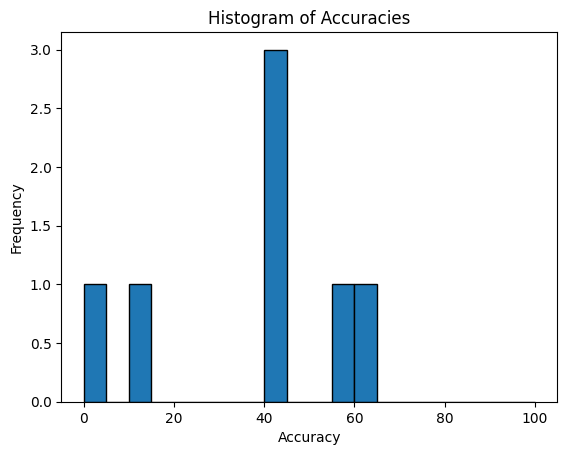

In [5]:
from matplotlib import pyplot as plt


def hist_accuracies(accuracies: list[float]) -> plt.Figure:
    fig, ax = plt.subplots()
    ax.hist(accuracies, bins=20, range=(0, 100), edgecolor="black")
    ax.set_title("Histogram of Accuracies")
    ax.set_xlabel("Accuracy")
    ax.set_ylabel("Frequency")
    return fig


fig = hist_accuracies([1, 14, 43, 63, 44, 44, 56])

In [16]:
train_loader, test_loader = CardioDataset.get_dataloaders(batch_size=64)

p = MLPParams(
    in_height=CardioDataset.input_size,
    in_bitwidth=16,
    out_height=CardioDataset.output_size,
    hidden_height=16,
    hidden_bitwidth=32,
    model_layers=4,
    learning_rate=0.01,
    activation=ActivationModule.RELU,
    epochs=30,
    dropout_rate=0.2,
    quantization_mode=QMode.DET,
)

evaluator = MLPEvaluator(train_loader, test_loader)

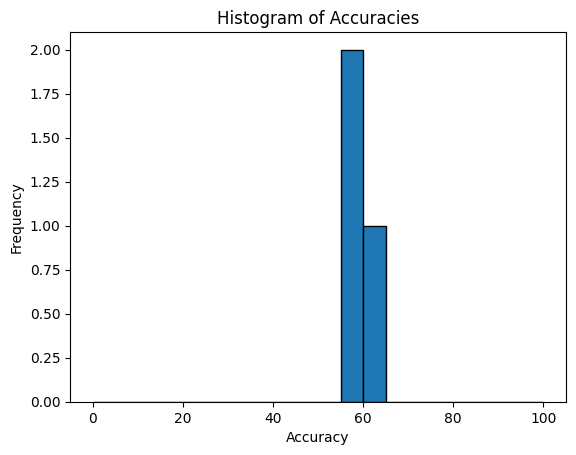

In [17]:
accuracies = []
for _ in range(3):
    best_acc = evaluator.train_model(p)
    accuracies.append(best_acc)

fig = hist_accuracies(accuracies)

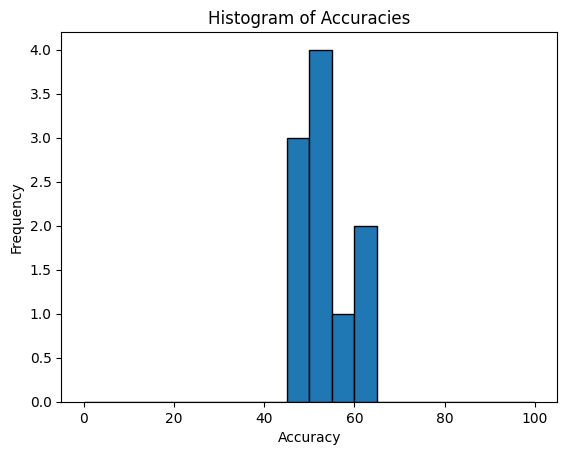

In [15]:
from dataclasses import replace

bnn_params = replace(p)
bnn_params.activation = ActivationModule.BINARIZE

accuracies = []
for _ in range(10):
    best_acc = evaluator.train_model(bnn_params)
    accuracies.append(best_acc)

fig = hist_accuracies(accuracies)

## Quantization techniques

- Bitwidth quantization
- BNN: Activation func (Using STE for gradients)
- BNN_ReSTE: Activation func (Changing gradients: ReSTE)
- TNN: Activation func (Differentiable?)
- ... Find more?

## How to integrate them

### MLP Model Parameters

- in height
- hidden layer height
- out height
- model_layers
- dropout rate
- learning rate
- weight decay
- use batch normalization
- Advanced: per hidden layer height
- training epochs

### CNN Model Parameters

- input_channels
- input_dimensions
- input_bitwidth
- output_height
- fc_height: int
- fc_layers: int
- fc_bitwidth: int
- conv_layers: list of objects
- ...

### Techniques Parameters

Bitwidth quantization parameters:
- Quantization mode (Deterministic, Stochastic)
- Input: Quantize to bits
- Hidden layers: Quantize to bits
- Advanced: Per input quantization
- Advanced: Per hidden layer quantization

BNN needs:
- Quantization mode

BNN_ReSTE:
- o
- t

TNN:
- None

### Integration

I'll need to create my own genome representation, since a fixed genome length will not suffice for this problem.